In [30]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
import praw

user_agent = "Scraper 1.0"
reddit = praw.Reddit(
    client_id = "gscPTd0wywq_IjgqoL1Smg",
    client_secret = "UAeWcM7eWeVXQVRJLZehtFq655Dzmw",
    user_agent = user_agent
)

In [32]:
headlines = set()

for submission in reddit.subreddit('politics').hot(limit = None):
    #print(submission.title)
    #print(submission.id)
    #print(submission.author)
    #print(submission.created_utc)
    #print(submission.score)
    #print(submission.upvote_ratio)
    #print(submission.url)
    #break
    headlines.add(submission.title)
for submission in reddit.subreddit('news').hot(limit = None):
    headlines.add(submission.title)
for submission in reddit.subreddit('worldnews').hot(limit = None):
    headlines.add(submission.title)
for submission in reddit.subreddit('technology').hot(limit = None):
    headlines.add(submission.title)
print(len(headlines))


1964


In [33]:
df = pd.DataFrame(headlines)
df.head()

,0
0,French intelligence says police vetted a suspe...
1,Canada's foreign affairs minister arrives in I...
2,Israel plans evacuation of Israeli northern re...
3,Real wars are now Flamewars - Why social media...
4,Microsoft’s Activision Blizzard acquisition is...


In [34]:
df.to_csv('headlines.csv', header = False, encoding = 'utf-8', index = False)

In [35]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/albert/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [36]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []
for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

pprint(results[:3], width = 100 )

[{'compound': -0.7845,
  'headline': 'French intelligence says police vetted a suspected attacker the day before knife '
              'killing at school.',
  'neg': 0.433,
  'neu': 0.433,
  'pos': 0.134},
 {'compound': -0.3182,
  'headline': "Canada's foreign affairs minister arrives in Israel amid Hamas conflict",
  'neg': 0.204,
  'neu': 0.796,
  'pos': 0.0},
 {'compound': 0.0,
  'headline': 'Israel plans evacuation of Israeli northern residents living up to 2 km from '
              "Lebanon's border",
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0}]


In [37]:
df = pd.DataFrame.from_records(results)
df.head()

,neg,neu,pos,compound,headline
0,0.433,0.433,0.134,-0.7845,French intelligence says police vetted a suspe...
1,0.204,0.796,0.000,-0.3182,Canada's foreign affairs minister arrives in I...
2,0.000,1.000,0.000,0.0000,Israel plans evacuation of Israeli northern re...
3,0.347,0.653,0.000,-0.8176,Real wars are now Flamewars - Why social media...
4,0.000,0.749,0.251,0.6908,Microsoft’s Activision Blizzard acquisition is...


In [38]:
df['label'] = 0 
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < 0.2, 'label'] = -1
df.loc[(0.2 > df['compound']) & (df['compound'] > -0.2), 'label'] = 0
df.head()



,neg,neu,pos,compound,headline,label
0,0.433,0.433,0.134,-0.7845,French intelligence says police vetted a suspe...,-1
1,0.204,0.796,0.000,-0.3182,Canada's foreign affairs minister arrives in I...,-1
2,0.000,1.000,0.000,0.0000,Israel plans evacuation of Israeli northern re...,0
3,0.347,0.653,0.000,-0.8176,Real wars are now Flamewars - Why social media...,-1
4,0.000,0.749,0.251,0.6908,Microsoft’s Activision Blizzard acquisition is...,1


In [39]:
df2 = df[['headline', 'label']]

In [40]:
df2.to_csv('reddit_headline_labels.csv', encoding = 'utf-8', index = False)

In [41]:
df.label.value_counts()

label
-1    812
 0    782
 1    370
Name: count, dtype: int64

In [42]:
df.label.value_counts(normalize = True) * 100

label
-1    41.344196
 0    39.816701
 1    18.839104
Name: proportion, dtype: float64

In [43]:
print("Positive headlines: \n")
pprint(list(df[df['label'] == 1].headline)[:5], width = 200)

print("\nNegative headlines: \n")
pprint(list(df[df['label'] == -1].headline)[:5], width = 200)

Positive headlines: 

['Microsoft’s Activision Blizzard acquisition is now clear to close after a UK regulator has given it a final stamp of approval.',
 'New California law creates Ebony Alert to find missing Black youth and women',
 'Cannabis firms are cut off from the US financial system, but relief is in sight; US Senate is eyeing a bill that would allow banks to do business with cannabis companies – now, if only they would '
 'vote on it',
 'Leaked Microsoft pay guidelines reveal salary, hiring bonus, and stock award ranges by level',
 'Rubio asks Biden administration to cancel visas for foreign nationals supporting Hamas']

Negative headlines: 

['French intelligence says police vetted a suspected attacker the day before knife killing at school.',
 "Canada's foreign affairs minister arrives in Israel amid Hamas conflict",
 'Real wars are now Flamewars - Why social media battles are now an integral part of modern day military conflict',
 'New York governor backs suspension of ‘rig

/tmp/ipykernel_6880/3139448537.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Negative", "Neutral", "Positive"])


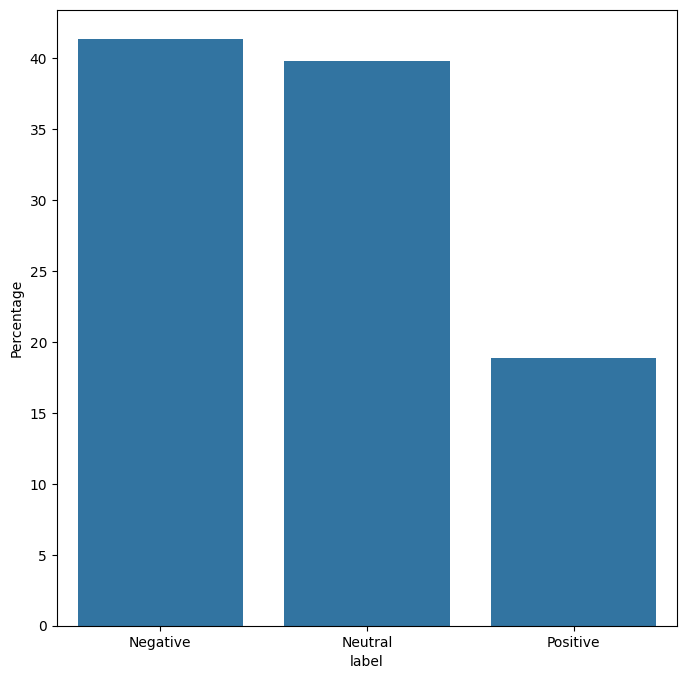

In [44]:
fig, ax = plt.subplots(figsize = (8, 8))
counts = df.label.value_counts(normalize = True)*100

sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(["Negative", "Neutral", "Positive"])
ax.set_ylabel("Percentage")
plt.show()

In [45]:
#compound score is the overall sentiment of the headline, 
#which can range from -1 to +1 with -1 being negative sentiment and +1 being positive
#final input into the ML models will be the compound score
compound = df[['compound', 'headline']]
compound.head()


,compound,headline
0,-0.7845,French intelligence says police vetted a suspe...
1,-0.3182,Canada's foreign affairs minister arrives in I...
2,0.0000,Israel plans evacuation of Israeli northern re...
3,-0.8176,Real wars are now Flamewars - Why social media...
4,0.6908,Microsoft’s Activision Blizzard acquisition is...


In [51]:
#average of all compound scores 
#normalized to [0,1] and expressed in percentage
mean = df["compound"].mean()
mean = ((mean+1)/2)*100
print(mean)

43.115656822810585
